In [65]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
utils = __import__("06-CV-utils")



# Computer Vision Tutorial

In this tutorial, you will learn how to train a Convolutional Neural Network (CNN) for image classification and how to use transfer learning. You can read more about the transfer learning at [cs231n notes](https://cs231n.github.io/transfer-learning/.)

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

Therefore there exists three main scenarios when training a CNN:
-  **Train the network from scratch**: we randomly initialize the weights in every layers.
-  **ConvNet as fixed feature extractor**: we load the pretrained
   weights and we freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.
-  **Finetuning the convnet**: Instead of random initialization, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.

## The most common CNN: The ResNet
In the following we will put in practice these scenarios by training (or finetuning) the most commonly used CNN: the Residual Network (ResNet). 
This network deeply reduces the problem of *vanishing gradients* thanks to the employment of *skipping connections*.  The figure in the following better illustrates this architectural trick:

<div>
<img src="https://www.researchgate.net/publication/325430477/figure/fig4/AS:633970848960514@1528161837288/An-illustration-of-the-modified-deep-residual-network-ResNetPlus-structure-The-blue.png" width="500"/>
</div>


This allows us to train CNN in a very stable (and easy) way. Not only, it also enable the deployment of several ResNet variants, suitable for different learning problems, but always achieving (even with the smallest ResNet 18) very high classification performance.
<div>
<img src="https://miro.medium.com/max/988/1*m8GPYCU9c02ftwDk8r_8Fg.png" height="250"/>
<img src="https://miro.medium.com/max/1384/1*r1c1C2RY8tkR_SvdV6aHsw.png" height="180"/>
</div>

All of them are implemented in [torchvision](https://pytorch.org/vision/main/models.html) which also provides their pretrained version on ImageNet. 

In [67]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import wget
import zipfile

cudnn.benchmark = True
plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda:0


## Load Data

The problem we're going to solve today is to train a model to classify
**ants** and **bees**. We have about 120 training images each for ants and bees.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Therefore it is a good scenario to understand the powerfulness of transfer learning.

This dataset is a very small subset of Imagenet composed of these two classes only.

We use the "wget" and "ZipFile" libraries to download and extract the data to the /data directory. 
<!-- .. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory. -->

In [68]:
import shutil

data_dir = "hymenoptera_data"
DELETE_DATA_DIR = False

if os.path.exists(data_dir) and DELETE_DATA_DIR:
  shutil.rmtree(data_dir)  # make sure there is nothing in our folder

os.makedirs(data_dir)  # create folders
wget.download(
  "https://download.pytorch.org/tutorial/hymenoptera_data.zip", data_dir
)  # download dataset
with zipfile.ZipFile(os.path.join(data_dir, "hymenoptera_data.zip"), "r") as zip_ref:
  zip_ref.extractall(".")  # extract dataset


As it commonly happens, the data are already split into "train" and "val" data. Furthermore each folder is split again into "ants" and "bees". This is exactly the configuration needed for the ``ImageFolder`` Dataset class (from ``torchvision.datasets``). It will automatically create a dataset returning the images and the label corresponding to the folder the images have been saved to. 

Also notice that ``ImageFolder`` requires two parameters to be passed:
*    ``root``: is the folder where the dataset is stored, for the train dataset it is ``hymenoptera_data/train`` or ``hymnoptera_data/val``
*    ``transform``: this is something **new**, transforms are used to convert the image data into a tensor, center it and normalize it (``ToTensor()``, ``Normalize(mean, variance)`` ``CenterCrop(size)``)

For the training transforms, however, you can also apply *data augmentation*: at each iteration we modify a little bit the image seen by the model. In this case we only do 
*   ``RandomResizedCrop(size, [ratio_min, ratio_max])`` which feeds the network with only a part of the original image
<!-- *   ``ColorJitter`` which randomly change the colors and the exposition of the image -->
*   ``RandomHorizontalFlip()`` which returnes the the mirrored image with 50% probability. 


In [69]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose(
  [
    transforms.RandomResizedCrop(224, [0.75, 1.0]),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  ]
)
# Just normalization for validation
val_transforms = transforms.Compose(
  [
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
  ]
)

train_dir = os.path.join(data_dir, "train")
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dir = os.path.join(data_dir, "val")
val_dataset = datasets.ImageFolder(root=val_dir, transform=val_transforms)

train_size = len(train_dataset)
val_size = len(val_dataset)

print("Dataset sizes:", train_size, val_size)

class_names = train_dataset.classes

print("Class names:", class_names)


Dataset sizes: 244 153
Class names: ['ants', 'bees']


Now we have to create the dataloader, as we in the previous lab for the logistic regression. Notice however that we are using one extra parameter:

*   ``num_workers`` is used to *parallelize* the loading from disk. 

Indeed, image datasets are too big normally to fit in memory and images are loaded from disk at every batch. In this case we do that using 4 threads to load the 16 images in parallel (4 per thread). 


In [70]:
batch_size = 16
train_dl = torch.utils.data.DataLoader(
  train_dataset, shuffle=True, batch_size=batch_size, num_workers=4
)
val_dl = torch.utils.data.DataLoader(
  val_dataset, batch_size=batch_size * 2, num_workers=4
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Visualize a few images
Let's visualize a few training images so as to understand *data
augmentation*. 



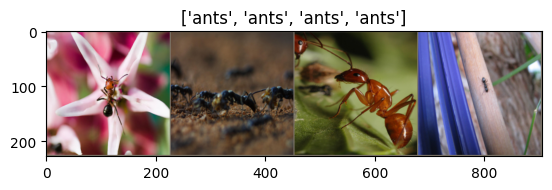

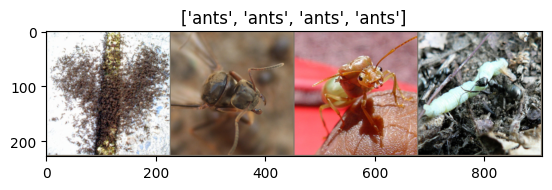

In [71]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # reconvert to numpy tensor
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean                  # take out normalization
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)                   # pause a bit so that plots are updated


# Get a batch of training data
x, classes = next(iter(train_dl))

# Make a grid from batch
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images

imshow(out, title=[class_names[c] for c in classes[:4]])

# Redo for valid data
x, classes = next(iter(val_dl))
out = torchvision.utils.make_grid(x[:4]) # we only plot the first 4 images
imshow(out, title=[class_names[c] for c in classes[:4]])

As you may notice the images in the first row (corresponding to the training data batch) are not centerd and colors are slightly changed.  

## Training the model

Now, let's write a general function to train a model. As you can see is very similar to the function that we used to train the Logistic Regresion model. However I preferred to put the training step and the evaluation step in two distinct function to better structurize the code.

In [72]:
# Function to iterate over data while training
def train_one_epoch(model, train_dl, loss, optim, device):        
    model.train()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        
        # zero the parameter gradients
        optim.zero_grad()

        # forward
        outputs = model(x)
        preds = torch.argmax(outputs, 1)
        l = loss(outputs, y)

        # backward + optimize 
        l.backward()
        optim.step()

        # statistics
        cur_loss += l.item() * x.size(0)
        cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(train_dl.dataset)
    epoch_acc = cur_acc.double() / len(train_dl.dataset)
    return epoch_loss, epoch_acc
    
# Function to iterate over data while evaluating
def eval_one_epoch(model, val_dl, loss, device):        
    model.eval()  # Set model to training mode
    cur_loss, cur_acc = 0.0, 0.0
    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            
            # forward
            outputs = model(x)
            preds = torch.argmax(outputs, 1)
            l = loss(outputs, y)

            # statistics
            cur_loss += l.item() * x.size(0)
            cur_acc += torch.sum(preds == y.data)

    epoch_loss = cur_loss / len(val_dl.dataset)
    epoch_acc = cur_acc.double() / len(val_dl.dataset)
    return epoch_loss, epoch_acc

def train_model(model, train_dl, val_dl, loss, optim, num_epochs=25):
    model.to(device)
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        train_loss, train_acc = train_one_epoch(model, train_dl, loss, optim, device)
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')

        val_loss, val_acc = eval_one_epoch(model, val_dl, loss, device)
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n')

        # save the best model
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "temp_model.pt")

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load("temp_model.pt"))
    return model

### Visualizing the model predictions

Generic function to display model  predictions for a few images.




In [73]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (x, y) in enumerate(val_dl):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            _, preds = torch.max(outputs, 1)

            for j in range(x.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(x.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Training a CNN from scratch 
For this notebook we will use the simplest of the ResNet models, the ResNet18 ([link](https://arxiv.org/abs/1512.03385) to the paper).

To do so, we simply instantiate the model (``torchvision.models.resnet18(num_classes)``) as we used to do also for the Logistic regression and we train it for a few epochs. Remember as well to:


*   Select the loss to employ
*   Instantiate an optimizer

The complete training (for 20 epochs) should take about 1-2 mins. 





In [74]:
import torch.nn.functional as F

num_classes = 2
lr = 0.001

# Model
model = torchvision.models.resnet18(num_classes=num_classes).to(device)

# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.AdamW(params=model.parameters(), lr=lr)

# Function
model = train_model(
  model=model, train_dl=train_dl, val_dl=val_dl, loss=loss, optim=opt, num_epochs=20
)


Epoch 0/19
----------
Train Loss: 0.9730 Acc: 0.5492
Val Loss: 5.1587 Acc: 0.4706

Epoch 1/19
----------
Train Loss: 0.6817 Acc: 0.6311
Val Loss: 2.1145 Acc: 0.5359

Epoch 2/19
----------
Train Loss: 0.6991 Acc: 0.6025
Val Loss: 0.8480 Acc: 0.6144

Epoch 3/19
----------
Train Loss: 0.5983 Acc: 0.6721
Val Loss: 0.5913 Acc: 0.6797

Epoch 4/19
----------
Train Loss: 0.5914 Acc: 0.6967
Val Loss: 0.5320 Acc: 0.7255

Epoch 5/19
----------
Train Loss: 0.6163 Acc: 0.6557
Val Loss: 0.6212 Acc: 0.6667

Epoch 6/19
----------
Train Loss: 0.5239 Acc: 0.7336
Val Loss: 0.5440 Acc: 0.6993

Epoch 7/19
----------
Train Loss: 0.5794 Acc: 0.6926
Val Loss: 0.7447 Acc: 0.6536

Epoch 8/19
----------
Train Loss: 0.5837 Acc: 0.7008
Val Loss: 0.9614 Acc: 0.6013

Epoch 9/19
----------
Train Loss: 0.5419 Acc: 0.7254
Val Loss: 0.7850 Acc: 0.6732

Epoch 10/19
----------
Train Loss: 0.5128 Acc: 0.7295
Val Loss: 0.5472 Acc: 0.7320

Epoch 11/19
----------
Train Loss: 0.5332 Acc: 0.7172
Val Loss: 0.5965 Acc: 0.6993

Ep

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [75]:
## FILL IT YOURSELF!

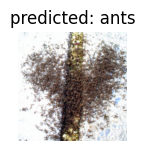

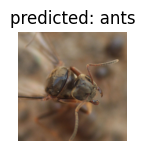

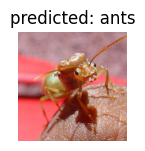

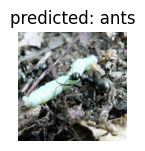

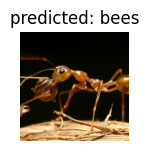

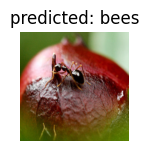

In [76]:
visualize_model(model)

The model that we trained is not very accurate. Why? Because CNN are incredibly complex models and to be traned properly (without overfitting), they need to "see" a sufficiently large representation of the world. For this reason, most of the time we start at least from a network pretrained on the ImageNet dataset (1M samples).

## Finetune a CNN
To Finetune a CNN we need to do three steps:
*  Load the weights of the pretrained model: torchvision provides the weights pretrained Imagenet for each of the CNN implemented in the library (``weights=torchvision.models.ResNet18_Weights``). 
*  Reset the final fully connected layer: to do so we initialize a linear layer ``nn.Linear()`` as the last layer of the model which is ``model_ft.fc``



In [77]:
num_classes = 2
lr = 0.001

# Model
model_ft = torchvision.models.resnet18(
  weights=torchvision.models.ResNet18_Weights,
).to(device)
model_ft.fc = nn.Linear(in_features=model_ft.fc.in_features, out_features=num_classes)


# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.AdamW(params=model_ft.parameters(), lr=lr)

# Function
model_ft = train_model(
  model=model_ft, train_dl=train_dl, val_dl=val_dl, loss=loss, optim=opt, num_epochs=20
)


Epoch 0/19
----------
Train Loss: 0.8644 Acc: 0.7664
Val Loss: 48.0816 Acc: 0.5490

Epoch 1/19
----------
Train Loss: 0.8967 Acc: 0.7090
Val Loss: 1.6329 Acc: 0.6144

Epoch 2/19
----------
Train Loss: 0.5091 Acc: 0.7254
Val Loss: 0.3713 Acc: 0.8170

Epoch 3/19
----------
Train Loss: 0.3529 Acc: 0.8770
Val Loss: 0.6320 Acc: 0.6667

Epoch 4/19
----------
Train Loss: 0.2844 Acc: 0.9098
Val Loss: 0.6260 Acc: 0.6732

Epoch 5/19
----------
Train Loss: 0.2106 Acc: 0.8934
Val Loss: 1.9083 Acc: 0.5490

Epoch 6/19
----------
Train Loss: 0.2550 Acc: 0.8975
Val Loss: 0.5331 Acc: 0.7647

Epoch 7/19
----------
Train Loss: 0.2748 Acc: 0.8934
Val Loss: 0.4522 Acc: 0.8039

Epoch 8/19
----------
Train Loss: 0.3327 Acc: 0.8607
Val Loss: 0.5797 Acc: 0.7647

Epoch 9/19
----------
Train Loss: 0.2384 Acc: 0.8811
Val Loss: 0.4508 Acc: 0.8039

Epoch 10/19
----------
Train Loss: 0.1417 Acc: 0.9508
Val Loss: 0.4596 Acc: 0.8105

Epoch 11/19
----------
Train Loss: 0.2329 Acc: 0.9221
Val Loss: 2.3869 Acc: 0.4902

E

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

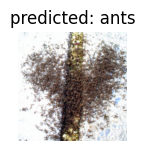

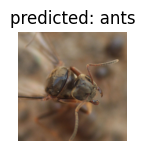

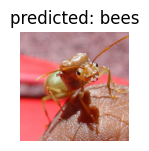

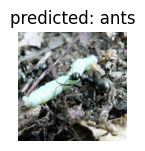

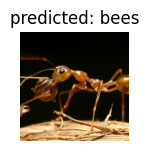

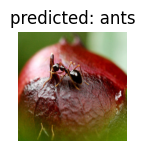

In [79]:
visualize_model(model_ft)

Indeed it seems that pretraining is working effectively. We got a pretty good validation accuracy (>90%).

## ConvNet as fixed feature extractor
In this case we only train the last layer of the network. For this reason we need to:

*  Pass to the optimizer only the weights of last layer ( ``model_fe.fc.parameters()``)
*  Freeze all the network except the final layer, by seting ``requires_grad = False`` to freeze the parameters so that the gradients are not computed in ``backward()`` and speed up the computation. You can read more about this in the documentation [here](https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward).

To train it will take less time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward still needs to be computed.


In [80]:
num_classes = 2
lr = 0.001

# Model
model_fe = torchvision.models.resnet18(
  weights=torchvision.models.ResNet18_Weights,
).to(device)

# Freeze all layers but last
model_fe.requires_grad_(False)
model_fe.fc = nn.Linear(in_features=model_fe.fc.in_features, out_features=num_classes)

# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.AdamW(params=model_fe.fc.parameters(), lr=lr)

# Function
model_fe = train_model(
  model=model_fe, train_dl=train_dl, val_dl=val_dl, loss=loss, optim=opt, num_epochs=20
)

Epoch 0/19
----------
Train Loss: 0.5391 Acc: 0.7254
Val Loss: 0.3848 Acc: 0.8627

Epoch 1/19
----------
Train Loss: 0.3941 Acc: 0.8484
Val Loss: 0.3744 Acc: 0.8627

Epoch 2/19
----------
Train Loss: 0.3141 Acc: 0.8893
Val Loss: 0.2539 Acc: 0.9281

Epoch 3/19
----------
Train Loss: 0.2395 Acc: 0.9385
Val Loss: 0.2410 Acc: 0.9216

Epoch 4/19
----------
Train Loss: 0.2329 Acc: 0.9180
Val Loss: 0.2623 Acc: 0.9085

Epoch 5/19
----------
Train Loss: 0.2233 Acc: 0.9262
Val Loss: 0.2103 Acc: 0.9346

Epoch 6/19
----------
Train Loss: 0.1863 Acc: 0.9303
Val Loss: 0.1942 Acc: 0.9477

Epoch 7/19
----------
Train Loss: 0.1764 Acc: 0.9385
Val Loss: 0.1946 Acc: 0.9346

Epoch 8/19
----------
Train Loss: 0.2830 Acc: 0.8852
Val Loss: 0.1848 Acc: 0.9346

Epoch 9/19
----------
Train Loss: 0.1713 Acc: 0.9344
Val Loss: 0.2064 Acc: 0.9281

Epoch 10/19
----------
Train Loss: 0.1461 Acc: 0.9549
Val Loss: 0.1751 Acc: 0.9412

Epoch 11/19
----------
Train Loss: 0.1516 Acc: 0.9549
Val Loss: 0.1710 Acc: 0.9412

Ep

We actually got a better result with the CNN as Feature Extractor (about 95 %)! 

This is most likely due to the fact that in the previous case we were strongly overfitting the data distribution. Indeed, by modifying also the hidden layers, the model at hand is incredibly complex for the small ant-bees dataset. Therefore if you have small dataset is better to only train the last fc layer.

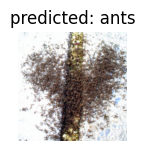

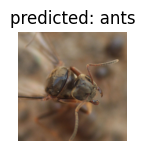

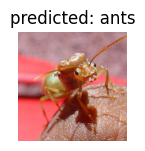

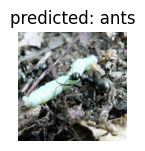

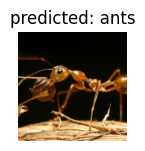

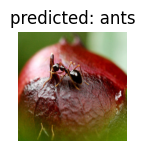

In [81]:
visualize_model(model_fe)

plt.ioff()
plt.show()

## But is it really necessary then to use the whole network?
No it is not. When doing transfer learning we can preprocess our datasets by passing the images through the convolutional layers.


In [87]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset

cnn_model = models.resnet18(weights=torchvision.models.ResNet18_Weights)
cnn_model.fc = torch.nn.Identity()

def extract_features(model, dl, device):
    model.to(device)
    x_extr, y_extr = [], []
    with torch.no_grad():
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            preds = cnn_model(x)
            x_extr.append(preds)
            y_extr.append(y)
        x_extr = torch.cat(x_extr, dim=0)
        y_extr = torch.cat(y_extr, dim=0)
        dataset_extr = TensorDataset(x_extr, y_extr)  
    return dataset_extr

# Extract the training dataset
trainset_extr = extract_features(cnn_model, train_dl, device)
train_dl_extr = DataLoader(trainset_extr, batch_size=16, shuffle=True)

# Extract the validation dataset
valset_extr = extract_features(cnn_model, val_dl, device)
val_dl_extr = DataLoader(trainset_extr, batch_size=16)

The extracted features can now be used to train only a linear layer (i.e., a logistic regression).

In [91]:
num_classes = 2
lr = 0.001

# Model

model_fe2 = nn.Linear(in_features=model_fe.fc.in_features, out_features=num_classes)

# Loss
loss = F.cross_entropy

# Optimizer
opt = optim.Adam(params=model_fe2.parameters(), lr=lr)

# Function
model_fe2 = train_model(
  model=model_fe2, train_dl=train_dl_extr, val_dl=val_dl_extr, loss=loss, optim=opt, num_epochs=20
)

Epoch 0/19
----------
Train Loss: 0.5758 Acc: 0.6844
Val Loss: 0.4269 Acc: 0.8443

Epoch 1/19
----------
Train Loss: 0.3500 Acc: 0.8852
Val Loss: 0.2928 Acc: 0.9098

Epoch 2/19
----------
Train Loss: 0.2686 Acc: 0.9180
Val Loss: 0.2564 Acc: 0.9180

Epoch 3/19
----------
Train Loss: 0.2544 Acc: 0.9098
Val Loss: 0.1950 Acc: 0.9385

Epoch 4/19
----------
Train Loss: 0.1919 Acc: 0.9385
Val Loss: 0.1824 Acc: 0.9508

Epoch 5/19
----------
Train Loss: 0.1762 Acc: 0.9467
Val Loss: 0.1752 Acc: 0.9426

Epoch 6/19
----------
Train Loss: 0.1675 Acc: 0.9508
Val Loss: 0.1468 Acc: 0.9590

Epoch 7/19
----------
Train Loss: 0.1489 Acc: 0.9467
Val Loss: 0.1436 Acc: 0.9672

Epoch 8/19
----------
Train Loss: 0.1416 Acc: 0.9713
Val Loss: 0.1269 Acc: 0.9672

Epoch 9/19
----------
Train Loss: 0.1462 Acc: 0.9549
Val Loss: 0.1402 Acc: 0.9549

Epoch 10/19
----------
Train Loss: 0.1183 Acc: 0.9672
Val Loss: 0.1270 Acc: 0.9672

Epoch 11/19
----------
Train Loss: 0.1221 Acc: 0.9754
Val Loss: 0.1045 Acc: 0.9795

Ep

Check the time required to train the network! We are several **order of magnitudes faster** (about 1s the whole training) than passing the data every time through the network. 

Notice, also, that the perforances are even higher than previously. This is related to the losing the data augmentation: the training set now is fixed and it seems that the data augmentation that we were using earlier was actually dangeruous. 

> Indeed, when using the resnet as a feature extractor, the training accuracy was always **lower** that the validation accuracy. This has to ring a bell. It means that you are regularizing too much your model (by means of the data augmentation) and you are not allowing it to fit the data.



## Long story short: don't do complex things if not required! 

*   Start simple: with transfer learning and extracted features
*   Only if required: increase the complexity of your learning strategy adding finetuning and data augmentation.
*   Train from scratch a CNN: only when the data distribution is highly different from the one of pretrained dataset (e.g., tumoral cell detection)